In [1]:
import pandas as pd
import glob 
import os
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import numpy as np
from sklearn.manifold import TSNE
#import umap
import umap.umap_ as umap
import seaborn as sns
import scipy.stats as sts
from scipy.interpolate import griddata

from helpers import *

In [2]:
save_dir = ''
file_names = glob.glob(os.path.join(save_dir, f'QCEH_data/TCV_DATAno*.parquet'))

List of dataframes (one discharge per each element of the list)

In [3]:
df_list = [pd.read_parquet(x) for x in file_names]
len(df_list)

60

# Initial Data Analysis
For this project we are only focusing on the machine inputs provided in the data.

In [4]:
GENERAL_INPUTS = ["shotnumber", "time"]
MACHINE_INPUTS = ["isbaffled", "ip","b0","nel","ptot","pdiv","q95","betan","kappa","deltaavg","deltaupp",
                  "deltalow","gapin","gapout","zmag","rmag","rmin","lpar_ot","zeff"]
LABEL = ["LHD_label"]
INPUTS = GENERAL_INPUTS + MACHINE_INPUTS + LABEL
len(INPUTS)

22

In [5]:
data = pd.concat(df_list, ignore_index=True)[INPUTS]
print(data.shape)
data.head(1)

(624858, 22)


,shotnumber,time,isbaffled,ip,b0,nel,ptot,pdiv,q95,betan,...,deltaupp,deltalow,gapin,gapout,zmag,rmag,rmin,lpar_ot,zeff,LHD_label
0,78600.0,0.65,1.0,-168210.37515,-1.442735,3.756246e+19,175726.540319,0.01331,4.560044,0.732083,...,0.34732,0.683923,0.027576,0.034128,-0.019449,0.890963,0.224565,15.855245,1.555953,1.0


Before getting deep into the patterns and correlations of our data, we must understand it better.

As such we would like to know if the features are categorical or numerical, what are the ranges of values etc.

### Are the features numerical or categorical?

In [6]:
print("Number of unique values per feature")
data.nunique()

Number of unique values per feature


shotnumber        60
time           23571
isbaffled          2
ip            624858
b0            482384
nel           624858
ptot          624858
pdiv          619035
q95           624858
betan         624858
kappa         624858
deltaavg      624858
deltaupp      624858
deltalow      624852
gapin         623898
gapout        624846
zmag          624858
rmag          624830
rmin          624842
lpar_ot       618063
zeff          593196
LHD_label          3
dtype: int64

The **nunique** functions displays the number of unique values per feature. Looking at these it is safe to say that **shotnumber**, **isbaffled** and **LHD_label** are categorical.

One must still consider that each shot has an assigned unique shotnumber so we will only consider **isbaffled** and **LHD_label** to be **categorical**  and that **all others are numerical features**.

### What ranges do these features take?
Note that we are provided with the intended ranges, so all points outside of these cna be considered to be outliers

In [7]:
print(data["isbaffled"].value_counts())
print(data["LHD_label"].value_counts())

isbaffled
1.0    519828
0.0    105030
Name: count, dtype: int64
LHD_label
3.0    327115
1.0    153237
2.0    144506
Name: count, dtype: int64


We can see that **isbaffled** is a boolean value and is True in about 5/6th of the samples, and that **LHD_label** takes values {1,2,3} which we know to be respectively {L-mode, QCE H-mode and ELMy H-mode}. We can also see that about half of the samples are in state 3 and the other quarters are in 2 and 3.

Now we explore the statistics of the numerical features

In [8]:
data.describe()

,shotnumber,time,isbaffled,ip,b0,nel,ptot,pdiv,q95,betan,...,deltaupp,deltalow,gapin,gapout,zmag,rmag,rmin,lpar_ot,zeff,LHD_label
count,624858.000000,624858.000000,624858.000000,624858.000000,624858.000000,6.248580e+05,6.248580e+05,624858.000000,624858.000000,624858.000000,...,624858.000000,624858.000000,624858.000000,624858.000000,624858.000000,624858.000000,624858.000000,624858.000000,624858.000000,624858.000000
mean,74040.707255,1.180475,0.831914,-171576.191224,-1.434432,5.392963e+19,9.334049e+05,0.035056,4.599658,1.474483,...,0.342776,0.589259,0.030130,0.032774,-0.009592,0.905936,0.222350,19.276987,1.983120,2.278268
std,5263.061549,0.312433,0.373943,5914.187915,0.009572,1.575741e+19,3.538534e+05,0.029013,0.296005,0.452540,...,0.127254,0.082856,0.007693,0.007458,0.035352,0.007695,0.005613,7.686711,0.424545,0.831448
min,61056.000000,0.650000,0.000000,-208673.029569,-1.444082,1.581738e+19,7.271428e+04,0.002843,3.455022,0.292175,...,0.098603,0.209451,0.000000,0.014442,-0.078045,0.878867,0.201977,12.371704,1.078659,1.000000
25%,70313.000000,0.910300,1.000000,-172546.928673,-1.442735,4.283033e+19,7.772877e+05,0.017190,4.448671,1.248134,...,0.208675,0.560121,0.025440,0.028233,-0.030529,0.902355,0.219125,14.564235,1.671284,2.000000
50%,78058.000000,1.173200,1.000000,-171070.907180,-1.441908,5.581423e+19,1.109936e+06,0.027766,4.566280,1.624423,...,0.376676,0.594500,0.030328,0.032672,-0.014486,0.908193,0.222103,16.221398,1.925378,3.000000
75%,78518.000000,1.447000,1.000000,-168214.796957,-1.429359,6.460525e+19,1.164649e+06,0.044656,4.775158,1.780283,...,0.426111,0.634441,0.034796,0.035909,0.007195,0.911483,0.225884,21.566665,2.201146,3.000000
max,78656.000000,1.750000,1.000000,-164599.387828,-1.406120,1.021997e+20,1.321485e+06,0.249197,5.786981,2.586815,...,0.735847,0.727387,0.055782,0.060501,0.173800,0.919038,0.243370,72.994448,3.319004,3.000000


This description is interesting as it reflects the diversity of our data. Indeed, some of the features such as **b0** are negative while others like **nel** are positive and orders of magnitude larger.

This analysis reflects the importance of standardization. We will go for 0 means and unit variance.

Now we are particularly interested in the ranges of values of our features.

In [9]:
data_actual_min_max = pd.concat([data.min(axis = 0).rename("min"), data.max(axis = 0).rename("max")], axis = 1)

With the data, we are provided a range of values which these features should take. All points outside of these ranges can be considered to be outliers. 

### Detecting outliers

In [10]:
normal_feature_ranges = {"shotnumber":(61056, 78656), "time":(0.650,1.800), "isbaffled":(0,1), "ip":(-5*10**5,5*10**5),"b0":(-2,2),"nel":(10**18,5*10**20),"ptot":(10**4,3*10**6),"pdiv":(0,5*10**-1),"q95":(3,6),"betan":(0,3),"kappa":(1,2),"deltaavg":(0,1),"deltaupp":(0,1),
                  "deltalow":(0,1),"gapin":(0,0.1),"gapout":(0,0.1),"zmag":(-0.2,0.2),"rmag":(0.85,0.95),"rmin":(0.2,0.3),"lpar_ot":(0,100),"zeff":(1,5),"LHD_label":(1,3)}
df_normal_feature_ranges = pd.DataFrame(normal_feature_ranges, ["reasonable_min", "reasonable_max"]).T

data_min_max = pd.concat([data_actual_min_max, df_normal_feature_ranges], axis = 1)
data_min_max

,min,max,reasonable_min,reasonable_max
shotnumber,6.105600e+04,7.865600e+04,61056,78656
time,6.500000e-01,1.750000e+00,0.65,1.8
isbaffled,0.000000e+00,1.000000e+00,0,1
ip,-2.086730e+05,-1.645994e+05,-500000,500000
b0,-1.444082e+00,-1.406120e+00,-2,2
nel,1.581738e+19,1.021997e+20,1000000000000000000,500000000000000000000
ptot,7.271428e+04,1.321485e+06,10000,3000000
pdiv,2.842617e-03,2.491965e-01,0.0,0.5
q95,3.455022e+00,5.786981e+00,3,6
betan,2.921755e-01,2.586815e+00,0,3


Now we can see which of these features go over the range of reasonable feature values

In [11]:
pd.concat([(data_min_max["min"] < data_min_max["reasonable_min"]).rename("has_underflow"), (data_min_max["max"] > data_min_max["reasonable_max"]).rename("has_overflow")], axis = 1)

,has_underflow,has_overflow
shotnumber,False,False
time,False,False
isbaffled,False,False
ip,False,False
b0,False,False
nel,False,False
ptot,False,False
pdiv,False,False
q95,False,False
betan,False,False


None of the features underflow or overflow, as such we can conclude that we have no outliers! We may procede with our analysis while considering all data points.



### Are the shot numbers similar?

In [12]:
shotnumbers = list(set(data["shotnumber"]))
shotnumbers.sort()
shotnumbers

[61056.0,
 61057.0,
 64438.0,
 64467.0,
 64469.0,
 64495.0,
 64950.0,
 66166.0,
 66169.0,
 70302.0,
 70305.0,
 70306.0,
 70310.0,
 70311.0,
 70313.0,
 70654.0,
 70656.0,
 70657.0,
 71344.0,
 71345.0,
 71351.0,
 73532.0,
 73784.0,
 73785.0,
 73786.0,
 73838.0,
 73846.0,
 75461.0,
 75464.0,
 78058.0,
 78061.0,
 78064.0,
 78069.0,
 78089.0,
 78090.0,
 78091.0,
 78104.0,
 78260.0,
 78261.0,
 78262.0,
 78368.0,
 78382.0,
 78510.0,
 78512.0,
 78518.0,
 78521.0,
 78524.0,
 78597.0,
 78598.0,
 78600.0,
 78601.0,
 78602.0,
 78603.0,
 78604.0,
 78606.0,
 78608.0,
 78611.0,
 78637.0,
 78639.0,
 78656.0]

Looking at these shot numbers, we can see that some of them are back to back. As such we could imagine that these experiments were in batches. This will be interesting in our analyses, because we might have batches of similar shots with a few tweaks in the parameters. In that case, it will be interesting to compare the results of similar shots to see what small changes may yield better or worst results.

# Now we Visualize

In [13]:
# This normalizes the X values.
X, y, column_names = get_training_data(include_time = False, include_shotnumber = False, shot_indices = list(range(5)))
column_names

['isbaffled',
 'ip',
 'b0',
 'nel',
 'ptot',
 'pdiv',
 'q95',
 'betan',
 'kappa',
 'deltaavg',
 'deltaupp',
 'deltalow',
 'gapin',
 'gapout',
 'zmag',
 'rmag',
 'rmin',
 'lpar_ot',
 'zeff',
 'LHD_label']

In [14]:
X.shape

(55005, 19)

In [15]:
# Perform PCA
pca = PCA()
X_pca = pca.fit_transform(X)

In [16]:
# Print scaled eigenvalues of principal components
print("Percentage of variance of Principal Components:")
print(100 * pca.explained_variance_ / pca.explained_variance_.sum())

Percentage of variance of Principal Components:
[4.42995016e+01 2.62499814e+01 1.24292069e+01 7.03102268e+00
 3.74274644e+00 1.87852962e+00 1.82242849e+00 9.43667404e-01
 4.93019790e-01 4.30619447e-01 3.57177638e-01 1.99344005e-01
 6.90040638e-02 3.27137923e-02 1.22962298e-02 7.20669304e-03
 1.53390922e-03 3.01896321e-15 0.00000000e+00]


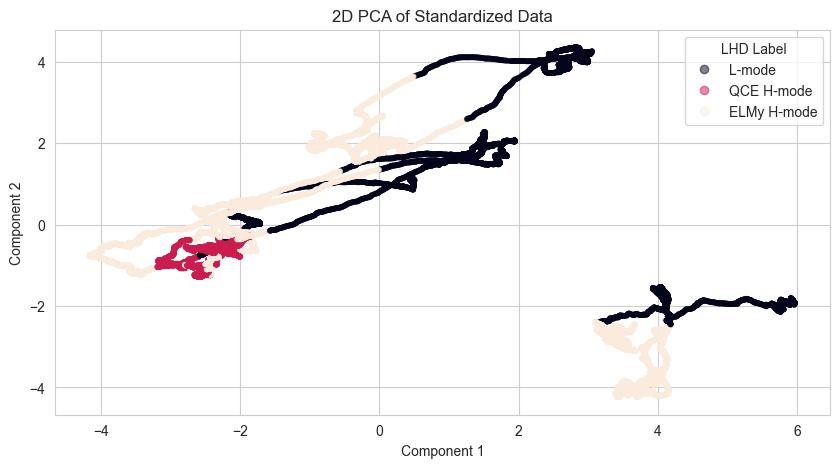

In [17]:
draw_reduced_space(X_pca[:, :2], y, n_components = 2, title = "2D PCA of Standardized Data")

# How about 3D

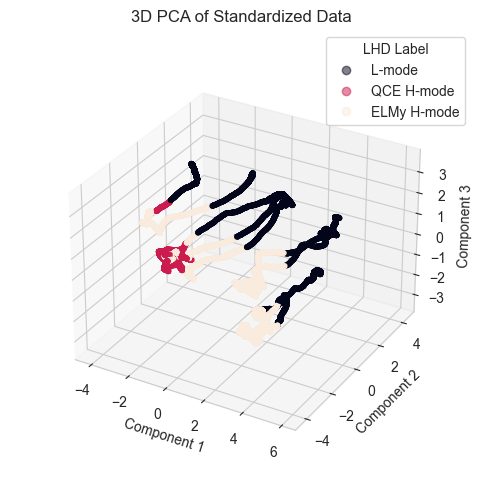

In [18]:
draw_reduced_space(X_pca[:, :3], y, n_components = 3, title = "3D PCA of Standardized Data")

# Analysis
Looking at the PCA for a single shot, we can see that the scatter plots follow a somewhat continuous path. As such we can expect Clustering Algorithms like DBSCAN to perform better than for instance K-means (which favor clusters that are spherical and not complex shapes of dense neighborhoods of points)

When considering 5 shots, we can already see that the scatter plots start overlapping; however, there are two clearly distinct clusters appearing. The initial hypothesis is that this change comes from the is_baffled state; however, this will need to be checked.

# Visualizing data, looking for patterns or clusters
TSNE is a more traditional approach to dimentionality reduction that somewhat maintains clusters 
It is very costly for high dimensionality datasets and UMAP solves that issue

As stated by the UMAP doc:

**n_neighbors**: This determines the number of neighboring points used in local approximations. Larger values will result in more global structure being preserved at the loss of detailed local structure. In general this parameter should often be in the range 5 to 50, with a choice of 10 to 15 being a sensible default.

**min_dist**: This controls how tightly the embedding is allowed compress points together. Larger values ensure embedded points are more evenly distributed, while smaller values allow the algorithm to optimise more accurately with regard to local structure. Sensible values are in the range 0.001 to 0.5, with 0.1 being a reasonable default.
Smaller min_distances are better for clustering
From there we try different UMAP settings

**n_components** parameter option that allows the user to determine the dimensionality of the reduced dimension space we will be embedding the data into.

/Users/ericsaikali/Library/Mobile Documents/com~apple~CloudDocs/Documents/GitHub/tokamak-unsupervised/venv/lib/python3.9/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


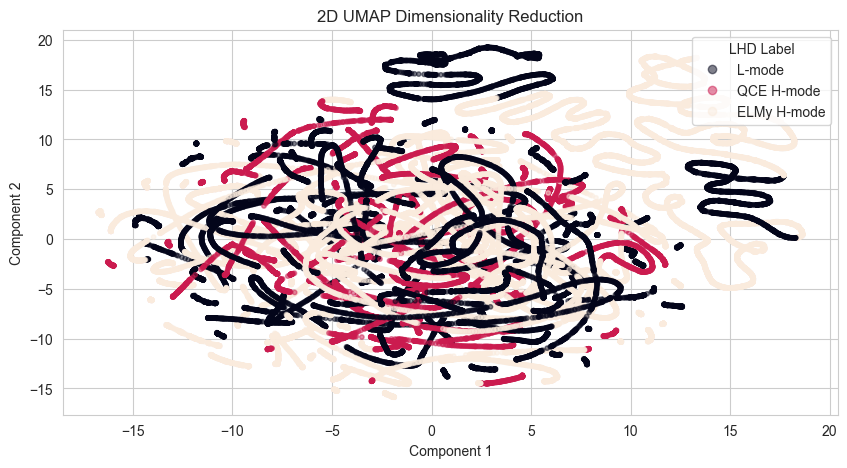

In [19]:
X_umap = perform_umap(X, n_neighbors=40, min_dist=0.1, n_components=2)[1]
draw_reduced_space(X_umap, y, n_components=2, title='2D UMAP Dimensionality Reduction')

Of course we can also plot a third component to get an even better view of the dimensionality reduction!

/Users/ericsaikali/Library/Mobile Documents/com~apple~CloudDocs/Documents/GitHub/tokamak-unsupervised/venv/lib/python3.9/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


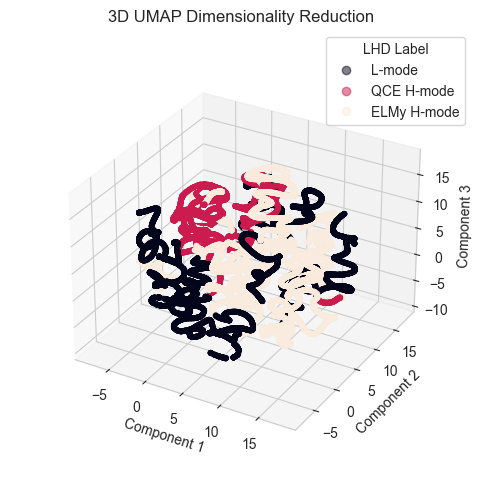

In [20]:
draw_reduced_space(perform_umap(X, n_neighbors=40, min_dist=0.1, n_components=3)[1], y, n_components=3, title='3D UMAP Dimensionality Reduction')

In [21]:
# we build a dataframe with the two main components and the label as columns
df_2_components = pd.DataFrame(
    data=X_umap, 
    columns=['Component1', 'Component2']) 

target_names = {
    1:'L-mode',
    2:'QCE H-mode', 
    3:'ELMy H-mode'
}
df_2_components['LHD label'] = y
df_2_components['LHD label'] = df_2_components['LHD label'].map(target_names)

# Heatmap of Label density in reduced space
Heatmaps help us see in which points of space a label is more likely to be present.

Of course, these visualizations don't take time into account; however, they still reveal that certain zones are more correlated with some LHD labels.

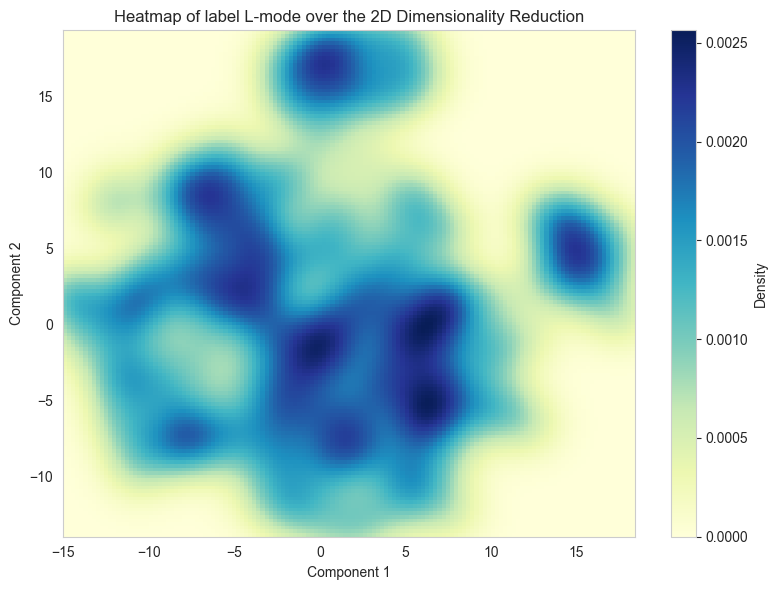

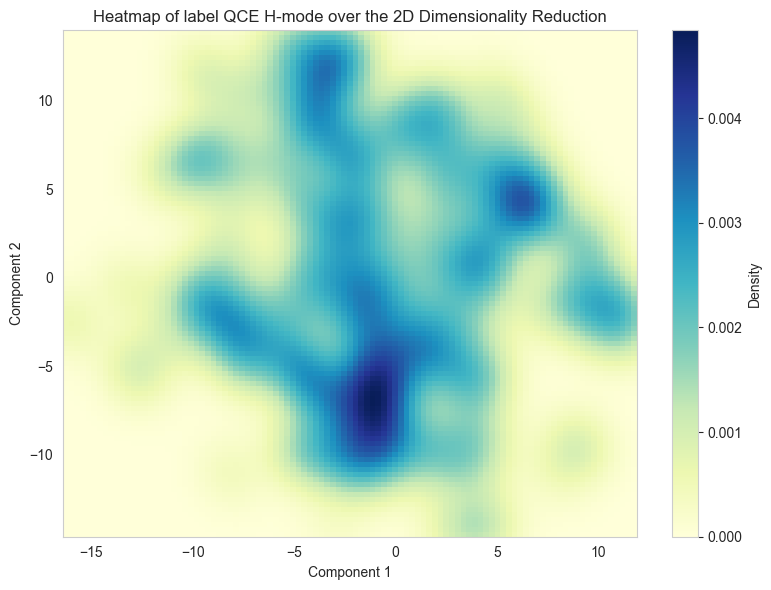

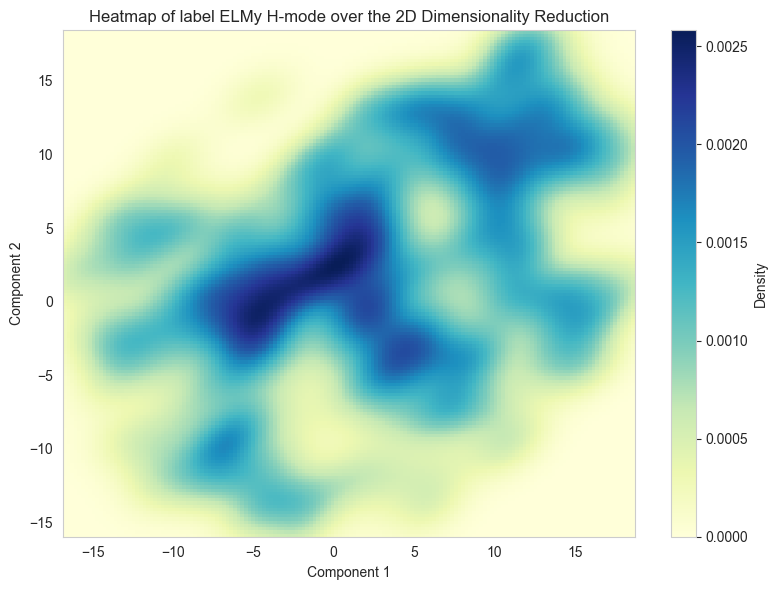

In [22]:
top_5_percent_indices = {}

for label in target_names.values():
    # Select data for the current label
    data = df_2_components[df_2_components['LHD label'] == label]
    pltx = data['Component1']
    plty = data['Component2']

    # Estimate the density
    k = sts.gaussian_kde([pltx, plty])
    xi, yi = np.mgrid[pltx.min():pltx.max():pltx.size**0.5*1j, plty.min():plty.max():plty.size**0.5*1j]
    zi = k(np.vstack([xi.flatten(), yi.flatten()]))

    # Plotting the density
    plt.figure(figsize=(8, 6))
    plt.pcolormesh(xi, yi, zi.reshape(xi.shape), shading='auto', cmap=plt.cm.YlGnBu)
    plt.colorbar(label='Density')
    plt.title(f'Heatmap of label {label} over the 2D Dimensionality Reduction')
    plt.xlabel('Component 1')
    plt.ylabel('Component 2')
    plt.tight_layout() 
    plt.show()

    # Find the threshold for the top 5%
    threshold = np.percentile(zi, 95)

    # Retrieve the indices of points above this threshold
    points_above_threshold = zi > threshold
    interpolated_points = griddata((xi.flatten(), yi.flatten()), points_above_threshold, (pltx, plty), method='nearest')
    top_5_percent_indices[label] = data[interpolated_points].index


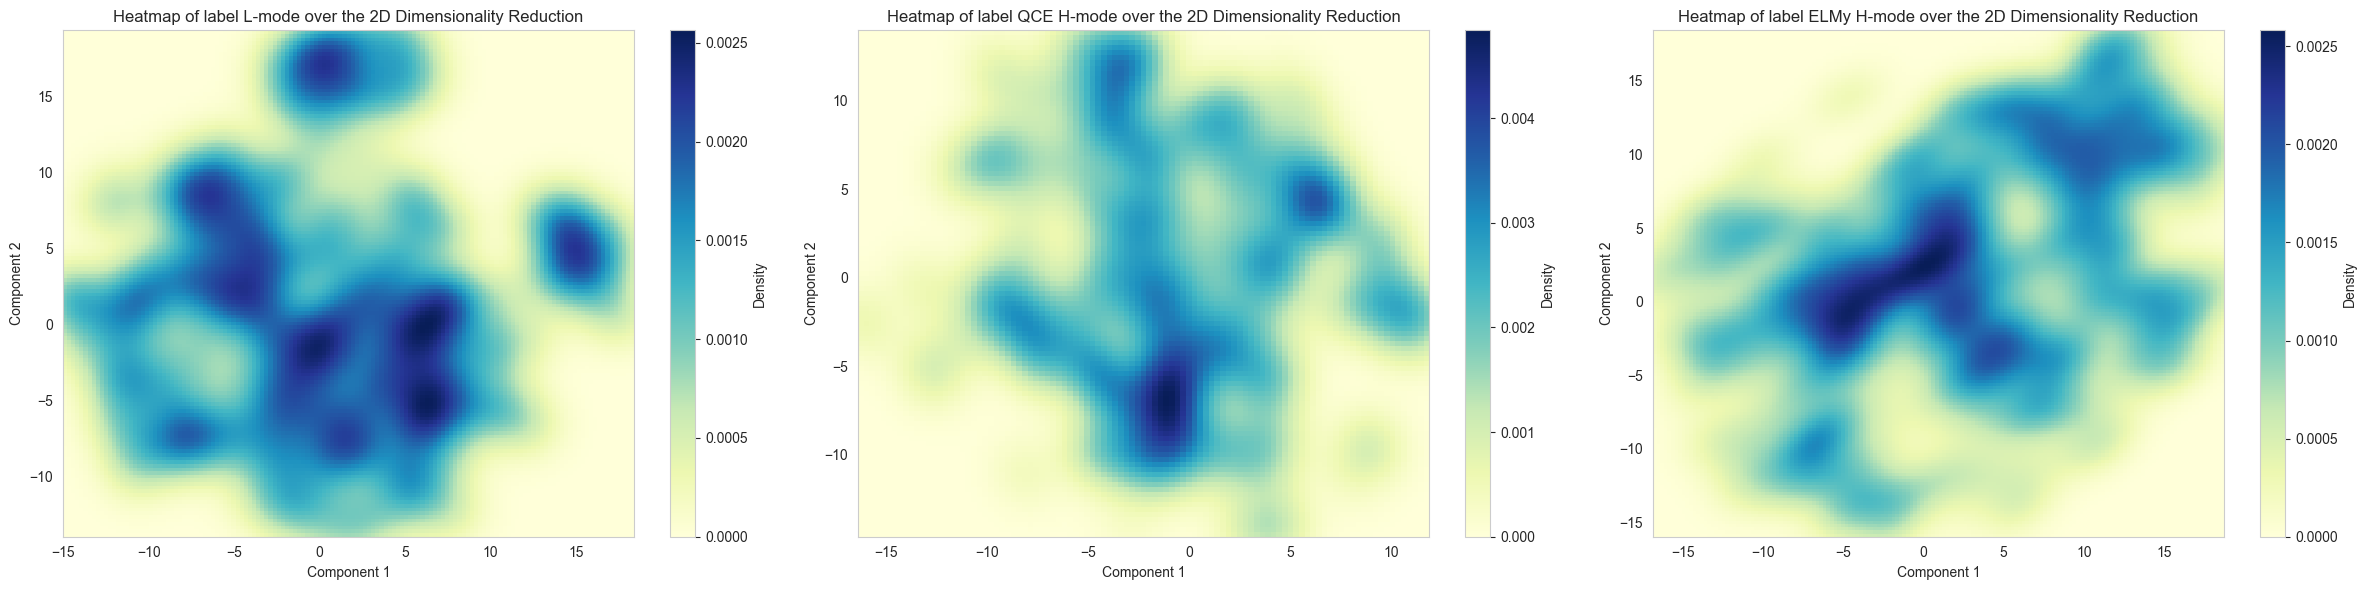

In [23]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as sts
from scipy.interpolate import griddata

# Assuming df_2_components and target_names are defined

# Number of labels
num_labels = len(target_names.values())

# Create a single figure with multiple subplots
fig, axes = plt.subplots(1, num_labels, figsize=(8 * num_labels, 6))

top_5_percent_indices = {}

for i, label in enumerate(target_names.values()):
    # Select data for the current label
    data = df_2_components[df_2_components['LHD label'] == label]
    pltx = data['Component1']
    plty = data['Component2']

    # Estimate the density
    k = sts.gaussian_kde([pltx, plty])
    xi, yi = np.mgrid[pltx.min():pltx.max():pltx.size**0.5*1j, plty.min():plty.max():plty.size**0.5*1j]
    zi = k(np.vstack([xi.flatten(), yi.flatten()]))

    # Plotting the density on the ith subplot
    ax = axes[i]
    pcm = ax.pcolormesh(xi, yi, zi.reshape(xi.shape), shading='auto', cmap=plt.cm.YlGnBu)
    fig.colorbar(pcm, ax=ax, label='Density')
    ax.set_title(f'Heatmap of label {label} over the 2D Dimensionality Reduction')
    ax.set_xlabel('Component 1')
    ax.set_ylabel('Component 2')

    # Find the threshold for the top 5%
    threshold = np.percentile(zi, 95)

    # Retrieve the indices of points above this threshold
    points_above_threshold = zi > threshold
    interpolated_points = griddata((xi.flatten(), yi.flatten()), points_above_threshold, (pltx, plty), method='nearest')
    top_5_percent_indices[label] = data[interpolated_points].index

plt.tight_layout()
plt.show()


Let's now invert the mapping and retrieve the features of the "hotspot" or agglomeration of samples displayed by each of the heatmaps

In [24]:
qce_h_top_5_percent = pd.DataFrame(X[top_5_percent_indices['QCE H-mode']], columns=column_names[:-1])
l_mode_top_5_percent = pd.DataFrame(X[top_5_percent_indices['L-mode']], columns=column_names[:-1])
elmy_h_mode_top_5_percent = pd.DataFrame(X[top_5_percent_indices['ELMy H-mode']], columns=column_names[:-1])

In [25]:
p_value_threshold = 0.05
qce_h_vs_l_mode_significance = []
qce_h_vs_elmy_significance = []
for feature in column_names[:-1]:
    # QCE H-mode vs L-mode
    _, p_value_qce_l = sts.mannwhitneyu(qce_h_top_5_percent[feature], l_mode_top_5_percent[feature])
    
    # QCE H-mode vs Elmy H-mode
    _, p_value_qce_elmy = sts.mannwhitneyu(qce_h_top_5_percent[feature], elmy_h_mode_top_5_percent[feature])
    
    if p_value_qce_l < p_value_threshold:
        qce_h_vs_l_mode_significance.append(feature)
    if p_value_qce_elmy < p_value_threshold:
        qce_h_vs_elmy_significance.append(feature)
        
print(f"Between QCE H-mode and L-mode: Mann-Whitney U Test displays a statistical difference at 95% confidence for {len(qce_h_vs_l_mode_significance)} features: {qce_h_vs_l_mode_significance} \n")
print(f"Between QCE H-mode and ELMy H-mode: Mann-Whitney U Test displays a statistical difference at 95% confidence for {len(qce_h_vs_elmy_significance)} features: {qce_h_vs_elmy_significance}")

Between QCE H-mode and L-mode: Mann-Whitney U Test displays a statistical difference at 95% confidence for 18 features: ['ip', 'b0', 'nel', 'ptot', 'pdiv', 'q95', 'betan', 'kappa', 'deltaavg', 'deltaupp', 'deltalow', 'gapin', 'gapout', 'zmag', 'rmag', 'rmin', 'lpar_ot', 'zeff'] 

Between QCE H-mode and ELMy H-mode: Mann-Whitney U Test displays a statistical difference at 95% confidence for 17 features: ['ip', 'b0', 'nel', 'pdiv', 'q95', 'betan', 'kappa', 'deltaavg', 'deltaupp', 'deltalow', 'gapin', 'gapout', 'zmag', 'rmag', 'rmin', 'lpar_ot', 'zeff']


In [26]:
print('Mean values for the QCE-H state "hotspot" :')
display(qce_h_top_5_percent.mean())

Mean values for the QCE-H state "hotspot" :


isbaffled    0.000000
ip           0.706750
b0          -0.498902
nel          0.707814
ptot         0.779010
pdiv        -0.046809
q95         -0.404551
betan        0.724779
kappa        0.115457
deltaavg     0.572378
deltaupp     0.308223
deltalow     0.583844
gapin        1.388704
gapout       0.401076
zmag        -0.818012
rmag         1.039798
rmin        -1.194077
lpar_ot     -0.563276
zeff         0.912157
dtype: float64

## Analysis
With these heatmaps we take every timestep as "independent" without considering the previous steps in the shot. Even if they allow to find values that indicate the desired state, the interpretability of these values is quite limited since independency here is a strong assumption.

In our next analyses we would like to consider the "history" of a shot.

Indeed, what we are really interested is how and how long it took for a shot to reach a certain point in space. In addition, we want to know how the label evolved as the timeseries happens.

To get answers to these questions we will have to consider time!

In [27]:
qce_h_mean = qce_h_top_5_percent.mean()
l_mode_mean = l_mode_top_5_percent.mean()
elmy_h_mode_mean = elmy_h_mode_top_5_percent.mean()
hotspots_mean = pd.concat([qce_h_mean, l_mode_mean, elmy_h_mode_mean], axis=1).T
hotspots_mean['Mode'] = ["QCE-H mode", "L-mode", "ELMy-H mode"]
hotspots_mean.to_csv('hotspots_mean.csv', index=False)